In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure
import json
import pickle
import collections

# Active Learning DEEPLAB V2

In [2]:
def get_test_score(folder, n_round=4, start_seed=0, total_seed=10):
    all_seed_scores = collections.defaultdict(list)

    for curr_SEED in range(start_seed, total_seed):
        num_folder = [f for f in os.listdir(folder) if f.isnumeric()]
        for dire in sorted(num_folder, key=lambda x: int(x)):
            for file_path in os.listdir(folder + dire):
                if file_path == f'test_score_SEED={curr_SEED}.npy':
                    test_score = list(np.load(folder + dire + '/' + file_path))
                    curr_score = all_seed_scores[curr_SEED]

                    if len(curr_score) and curr_score[-1] == test_score[0]:
                        test_score = test_score[1:]

                    all_seed_scores[curr_SEED] = curr_score + test_score      
    
    final_all_seed_scores = []
    for k, v in all_seed_scores.items():
        v = v[:n_round]
        if len(v) == n_round:
            final_all_seed_scores.append(v)
    return np.stack(final_all_seed_scores)

# current exp

In [3]:
EXP_FOLDER = '../../experiments/AL_segmentation/auris/'
VERSION = 'v4'
all_AL = [
    f"{VERSION}/AL_random/",
    f"{VERSION}/AL_density/",
    f"{VERSION}/AL_entropy/",
    f"{VERSION}/AL_density_entropy/",
    # f"{VERSION}/AL_kmeans_fulldataset_center_simCLR_bestTrainAcc/",
    # f"{VERSION}/AL_kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere/",
    # f"{VERSION}/AL_kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere_simpler/",
    # f"{VERSION}/AL_kmeans_fulldataset_center_resnet/",
    # f"{VERSION}/AL_density_entropy_21rds/",
    # f"{VERSION}/AL_kmeans_entropy_resnet/",
    # f"{VERSION}/AL_kmeans_fulldataset_entropy_resnet/",
    f"{VERSION}/AL_kmeans_fulldataset_entropy_simCLR/",
]

In [4]:
colors = ['black', 'blue', 'green', 'magenta', 'orange', 'magenta', 'cyan', 'yellow', "gray"]
# colors = ['black', 'blue', 'red', 'orange', 'magenta', 'cyan', 'yellow', "gray"]

all_scores = []
min_ = float('inf')
N_ROUND = 5

for name in all_AL:
    score = get_test_score(EXP_FOLDER + name, n_round=N_ROUND)
    all_scores.append(score)
    if score.shape[0] < min_:
        min_ = score.shape[0]
        print(min_, name)

start = 0
end = min_
all_scores_mean = [np.median(s[start: end],axis=0) for s in all_scores]
all_scores_std = [np.std(s[start: end], axis=0) for s in all_scores]

10 v4/AL_random/


In [5]:
mean = 0
full_dataset_path = EXP_FOLDER + f'{VERSION}/fulldataset'
folder = 0
seed = start
while seed < end:
    try:
        test = np.load(f'{full_dataset_path}/{folder}/test_score_SEED={seed}.npy')
        print(f'SEED={seed}', test[0])
        mean += test[0]
        seed += 1
    except:
        folder += 1

SEED=0 0.9003865222425677
SEED=1 0.8947271207812549
SEED=2 0.8914241691408499
SEED=3 0.9041159944248739
SEED=4 0.896107210867118
SEED=5 0.8957627276633922
SEED=6 0.891809031702062
SEED=7 0.9007114558528285
SEED=8 0.8956307784752385
SEED=9 0.904734345494674


In [6]:
x_axis = [10 + 10*i for i in range(N_ROUND)]
x_axis = [100 * i / 800 for i in x_axis]

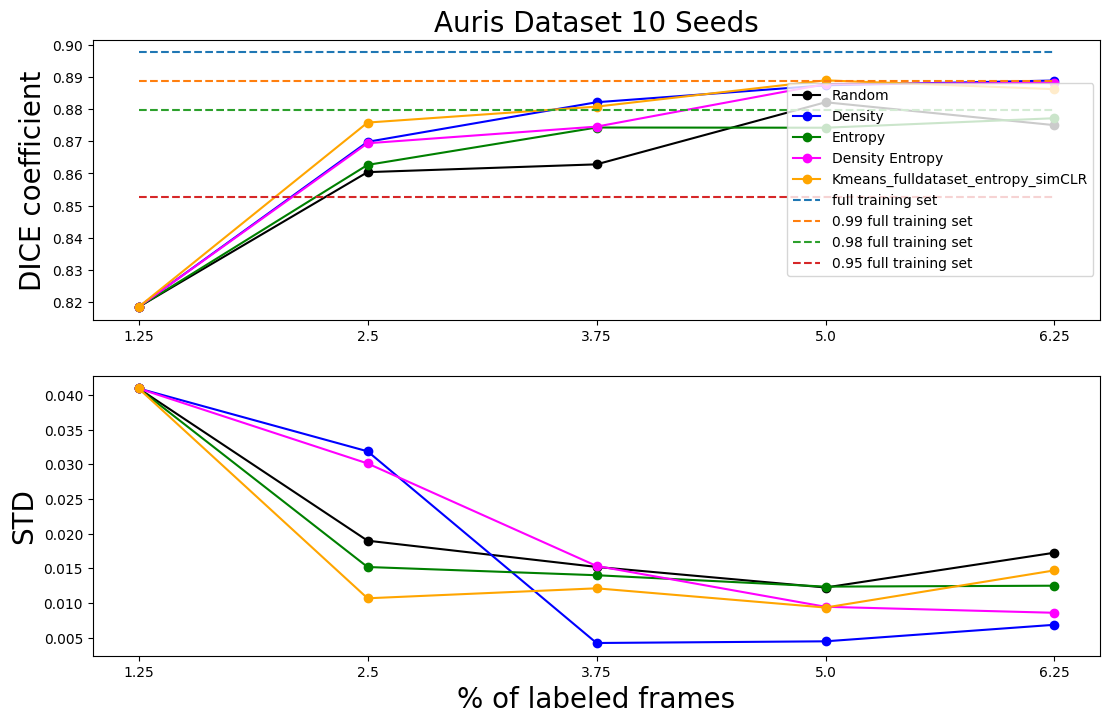

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(13, 8))
for i, score in enumerate(all_scores_mean):
    label = all_AL[i][6:-1]
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc':
        label = 'our Method'
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere':
        label = 'our Method with Sphere'
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere_simpler':
        label = 'our Method with Sphere simpler'
    if label == 'density_entropy':
        label = 'Density Entropy'
    # upper case label fist letter
    label = label[0].upper() + label[1:]
    axs[0].plot(score, '-o', label=label, color=colors[i])
    axs[1].plot(all_scores_std[i], '-o',color=colors[i])
axs[0].plot([mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='full training set')
axs[0].plot([0.99 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.99 full training set')
axs[0].plot([0.98 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.98 full training set')
axs[0].plot([0.95 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.95 full training set')

axs[1].set_xlabel('% of labeled frames',fontsize=20)
axs[0].set_ylabel('DICE coefficient', fontsize=20)
axs[1].set_ylabel('STD', fontsize=20)
axs[0].set_xticks(range(len(x_axis)))
axs[0].set_xticklabels(x_axis)
axs[1].set_xticks(range(len(x_axis)))
axs[1].set_xticklabels(x_axis)
# axs[0].set_title(f'Skateboard Dataset', fontsize=20)
axs[0].set_title(f'Auris Dataset {seed} Seeds', fontsize=20)
# put legend on the right
axs[0].legend(loc='center right');
# plt.savefig('../../../MICCAI/auris_results.pdf', bbox_inches='tight')

In [46]:
# legend font weight
for text in axs.get_legend().get_texts():
    print(text)
    text.set_fontweight('bold')

Text(0, 0, 'Random                     | 0.7256')
Text(0, 0, 'Temporal Coverage   | 0.7256')
Text(0, 0, 'Entropy                      | 0.7256')
Text(0, 0, 'Density Entropy         | 0.7256')
Text(0, 0, 'Our Method                | 0.7256')
Text(0, 0, 'full training set')
Text(0, 0, '0.99 full training set')
Text(0, 0, '0.98 full training set')
Text(0, 0, '0.95 full training set')


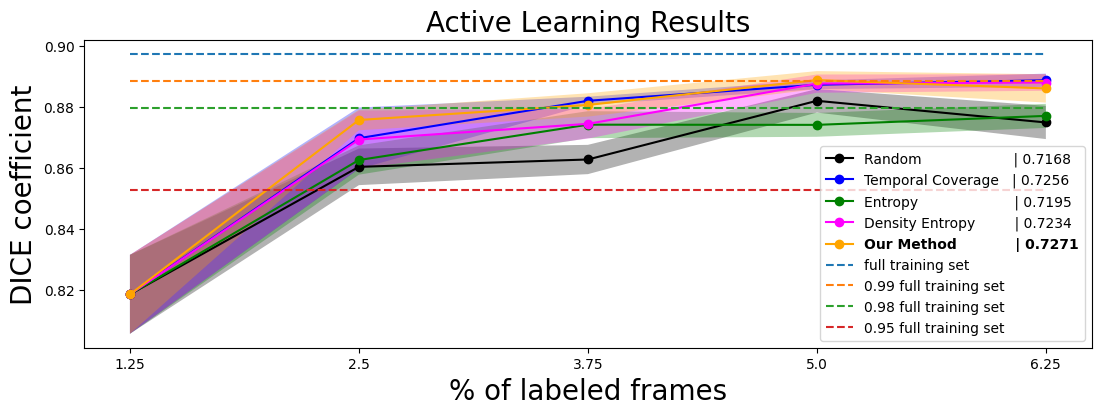

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(13, 4))
for i, score in enumerate(all_scores_mean):
    label = all_AL[i][6:-1]
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc':
        label = 'our Method'
    if label == 'kmeans_fulldataset_entropy_simCLR':
        label = 'our Method            | 0.7271'
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere':
        label = 'our Method with Sphere'
    if label == 'kmeans_fulldataset_center_simCLR_bestTrainAcc_sphere_simpler':
        label = 'our Method with Sphere simpler'
    if label == 'density_entropy':
        label = 'Density Entropy         | 0.7234'
    if label == 'density':
        label = 'Temporal Coverage   | 0.7256'
    if label == 'entropy':
        label = 'Entropy                      | 0.7195'
    if label == 'random':
        label = 'Random                     | 0.7168'

    # upper case label fist letter
    label = label[0].upper() + label[1:]
    axs.plot(score, '-o', label=label, color=colors[i])
    axs.fill_between(np.arange(len(score)), score + all_scores_std[i]/np.sqrt(seed), score - all_scores_std[i]/np.sqrt(seed), facecolor=colors[i], alpha=0.3)
axs.plot([mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='full training set')
axs.plot([0.99 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.99 full training set')
axs.plot([0.98 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.98 full training set')
axs.plot([0.95 * mean/(end - start) for i in range(len(all_scores_mean[0]))], '--', label='0.95 full training set')

axs.set_xlabel('% of labeled frames',fontsize=20)
axs.set_ylabel('DICE coefficient', fontsize=20)
axs.set_xticks(range(len(x_axis)))
axs.set_xticklabels(x_axis)
# axs[0].set_title(f'Skateboard Dataset', fontsize=20)
axs.set_title(f'Active Learning Results', fontsize=20)
# put legend on the right

axs.legend(loc='lower right');
for i, text in enumerate(axs.get_legend().get_texts()):
    if i == 4:
        text.set_fontweight('bold')
plt.savefig('../../../MICCAI/auris_AL.pdf', bbox_inches='tight')

In [52]:
text 

Text(0, 0, '0.95 full training set')